# Standard RB Demo

This is a very basic implemention of a standard RB experiment

In [1]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Running 1-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: c5dd7ef9-9010-4018-b712-9af413ff3ebb
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.45834121716795917 ± 0.12213198333255153
- alpha: 0.9981278928818351 ± 0.000703818873057736
- b: 0.5283572362051712 ± 0.12348653334949362
- reduced_chisq: 0.027050133485052932
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0009360535590824393
- EPC_err: 0.00035256948437020514
- success: True


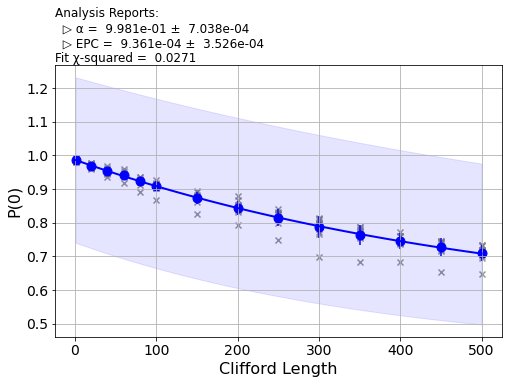

In [2]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
exp1 = rb.RBExperiment([0], lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 813ee9fd-282b-40b6-be84-be661add9ca4
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7101000847314624 ± 0.01546721965247631
- alpha: 0.970965133698129 ± 0.0019052336560767267
- b: 0.26714473313054565 ± 0.01133624398164095
- reduced_chisq: 0.0408025199263645
- dof: 7
- xrange: [1.0, 200.0]
- EPC: 0.021776149726403266
- EPC_err: 0.0014716545347155533
- success: True


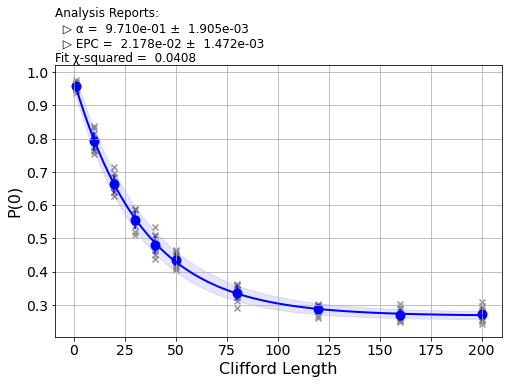

In [3]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an RB experiment on qubits 0, 1
exp2 = rb.RBExperiment([0, 1], lengths, num_samples=num_samples, seed=seed)
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Running 1-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRBExperiment
Experiment ID: 1596b9b3-7805-40eb-b4d8-5b76046cd597
Status: DONE
Circuits: 280
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.45866193425920665 ± 0.05274545942959851
- alpha: 0.998121682066491 ± 0.0003163124671680783
- alpha_c: 0.99898852822204 ± 0.0003108272580212771
- b: 0.5268424448338176 ± 0.053582504822380604
- reduced_chisq: 0.042458924579051045
- dof: 24
- xrange: [1.0, 500.0]
- EPC: 0.0005057358889800079
- EPC_err: 0.00015541362901063855
- EPC_systematic_err: 0.0013725820445290027
- EPC_systematic_bounds: [0, 0.0018783179335090106]
- success: True


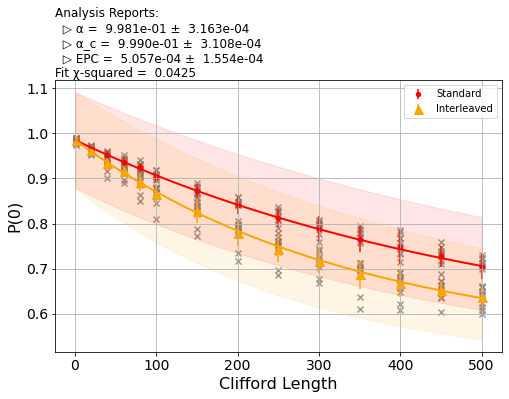

In [4]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
int_exp1 = rb.InterleavedRBExperiment(circuits.XGate(), [0], lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

# Running 2-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRBExperiment
Experiment ID: 25b8eddd-3870-4fd1-bfc1-669b8b2936a4
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7025910789890448 ± 0.012666513414869166
- alpha: 0.970612599176899 ± 0.001678935943989779
- alpha_c: 0.9834206895620717 ± 0.0028452724070327264
- b: 0.25733595618059046 ± 0.005070594525149778
- reduced_chisq: 0.1486612902280576
- dof: 16
- xrange: [1.0, 200.0]
- EPC: 0.012434482828446197
- EPC_err: 0.0021339543052745448
- EPC_systematic_err: 0.03164661840620528
- EPC_systematic_bounds: [0, 0.044081101234651476]
- success: True


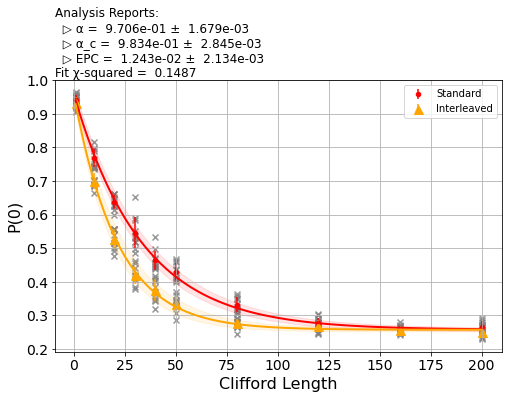

In [5]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an Interleaved RB experiment on qubits 4, 6
int_exp2 = rb.InterleavedRBExperiment(circuits.CXGate(), [4,6], lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

## Running parallel RB experiments

KeyError: 'num_qubits'

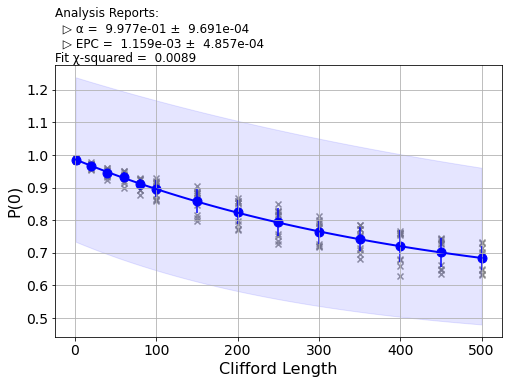

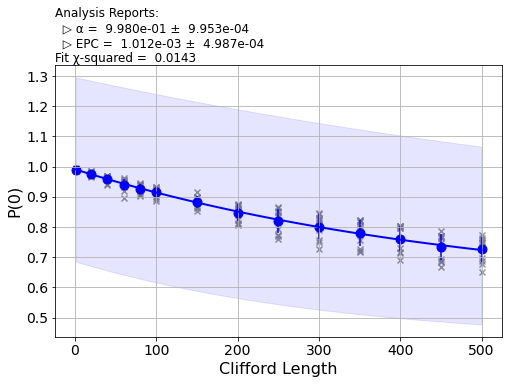

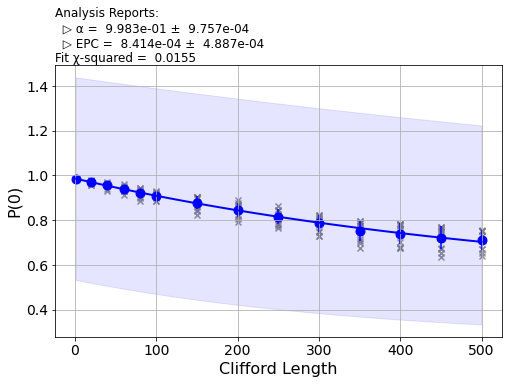

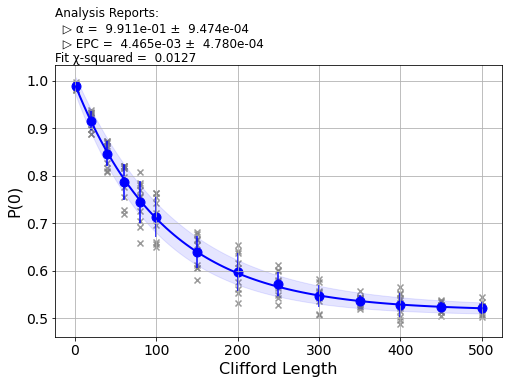

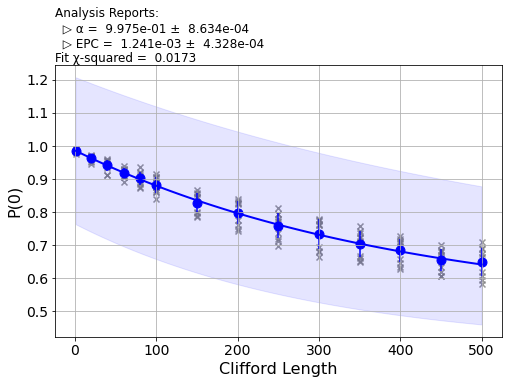

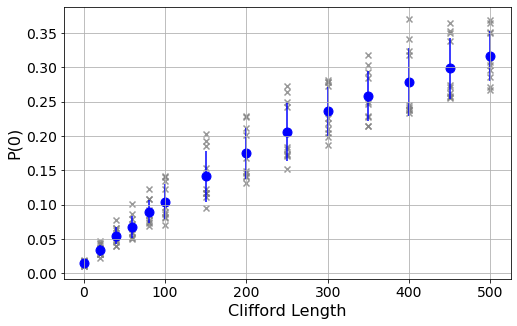

In [6]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed1 = 1010

exps = [rb.RBExperiment([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in range(5)]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [ ]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')